In [1]:
# === Section 1: Imports and Artifact Loading ===

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. Import all artifacts from our Part 0/1 pipeline
from data_pipeline import (
    train_iterator, 
    valid_iterator, 
    test_iterator, 
    TEXT, 
    LABEL, 
    create_embedding_layer,
    device  # This is the device (cuda or cpu)
)

# 2. Set constants from the loaded artifacts
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
OUTPUT_DIM = len(LABEL.vocab)
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

print(f"Data loaded. Using device: {device}")
print(f"Vocabulary size: {INPUT_DIM}")
print(f"Number of classes: {OUTPUT_DIM}")
print(f"Pad Token Index: {PAD_IDX}")

Data loaded. Using device: cpu
Vocabulary size: 7484
Number of classes: 6
Pad Token Index: 1


In [2]:
# === Section 2: Model Definitions ===

# --- Model 1: Final Hidden State (Baseline) ---
class RNN_Hidden(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        # 1. Embedding Layer (from data_pipeline)
        self.embedding = create_embedding_layer(freeze=False) # Learnable
        
        # 2. Simple RNN Layer
        self.rnn = nn.RNN(embedding_dim, 
                          hidden_dim, 
                          num_layers = n_layers, 
                          bidirectional = bidirectional, 
                          dropout = dropout if n_layers > 1 else 0)
        
        # 3. Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        # 4. Dropout Layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text_tuple):
        
        # text_tuple is (text, lengths) from BucketIterator
        # text = [seq_len, batch_size]
        # lengths = [batch_size]
        text, text_lengths = text_tuple
        
        # 1. Pass through embedding layer and apply dropout
        # embedded = [seq_len, batch_size, emb_dim]
        embedded = self.dropout(self.embedding(text))
        
        # 2. Pack the padded sequence 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), 
                                                          enforce_sorted=False)
            
        # 3. Run the RNN
        packed_output, hidden = self.rnn(packed_embedded)
        
        # 4. AGGREGATION (Q2d): Use the final hidden state
        # hidden = [n_layers * n_directions, batch_size, hid_dim]
        hidden = self.dropout(hidden.squeeze(0)) # Squeeze for [batch_size, hid_dim]
        
        # 5. Pass to the final linear layer
        return self.fc(hidden)


# --- Model 2: Average Pooling (for Q2d) ---
class RNN_AvgPool(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = create_embedding_layer(freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = n_layers, 
                          bidirectional = bidirectional, dropout = dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text_tuple):
        text, text_lengths = text_tuple
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), 
                                                          enforce_sorted=False)
        
        # output = [seq_len, batch_size, hid_dim * num_directions]
        output, hidden = self.rnn(packed_embedded)
        
        # Unpack the output
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(output)
        
        # --- AGGREGATION (Q2d): Average Pooling ---
        # Permute to [batch_size, seq_len, hid_dim]
        output = output.permute(1, 0, 2)
        
        # Create a mask to ignore padding [batch_size, seq_len, 1]
        mask = (torch.arange(output.shape[1])[None, :] < output_lengths[:, None]).to(device)
        mask = mask.unsqueeze(2).float()
        
        # Sum non-padded states and divide by true length
        masked_output = output * mask
        summed_output = torch.sum(masked_output, dim=1)
        avg_pooled = summed_output / output_lengths.unsqueeze(1).float() 
        
        return self.fc(self.dropout(avg_pooled))

# --- Model 3: Max Pooling (for Q2d) ---
class RNN_MaxPool(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = create_embedding_layer(freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = n_layers, 
                          bidirectional = bidirectional, dropout = dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text_tuple):
        text, text_lengths = text_tuple
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'),
                                                          enforce_sorted=False)
        
        output, hidden = self.rnn(packed_embedded)
        
        # Unpack the output
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(output)
        
        # --- AGGREGATION (Q2d): Max Pooling ---
        # Permute to [batch_size, hid_dim, seq_len] for MaxPool1d
        output = output.permute(1, 2, 0)
        
        # Apply MaxPool1d over the sequence length
        max_pooled = F.max_pool1d(output, output.shape[2]).squeeze(2)
        
        return self.fc(self.dropout(max_pooled))

print("All 3 RNN model architectures defined (Baseline, AvgPool, MaxPool).")

All 3 RNN model architectures defined (Baseline, AvgPool, MaxPool).


In [3]:
# === Section 3: Helper Functions (with EarlyStopping) ===

# --- NEW: EarlyStopping Class ---
# This class will stop training if val_loss doesn't improve for 'patience' epochs
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
# --- END NEW CLASS ---

def categorical_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train_epoch(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_epoch(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text)
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

print("Training & evaluation helper functions defined.")

Training & evaluation helper functions defined.


Starting Baseline RNN model training...
Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 1.546 | Train Acc: 32.66%
	 Val. Loss: 1.392 |  Val. Acc: 42.01%
Validation loss decreased (inf --> 1.391744).  Saving model ...
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.180 | Train Acc: 53.37%
	 Val. Loss: 1.070 |  Val. Acc: 58.94%
Validation loss decreased (1.391744 --> 1.070100).  Saving model ...
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.035 | Train Acc: 61.92%
	 Val. Loss: 0.967 |  Val. Acc: 65.89%
Validation loss decreased (1.070100 --> 0.967398).  Saving model ...
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.861 | Train Acc: 69.01%
	 Val. Loss: 0.907 |  Val. Acc: 67.53%
Validation loss decreased (0.967398 --> 0.906988).  Saving model ...
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.784 | Train Acc: 72.79%
	 Val. Loss: 1.019 |  Val. Acc: 59.64%
EarlyStopping counter: 1 out of 3
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.651 | Train Acc: 77.44%
	 Val. Loss: 0.694 |  Val. Acc: 73.26%
Validat

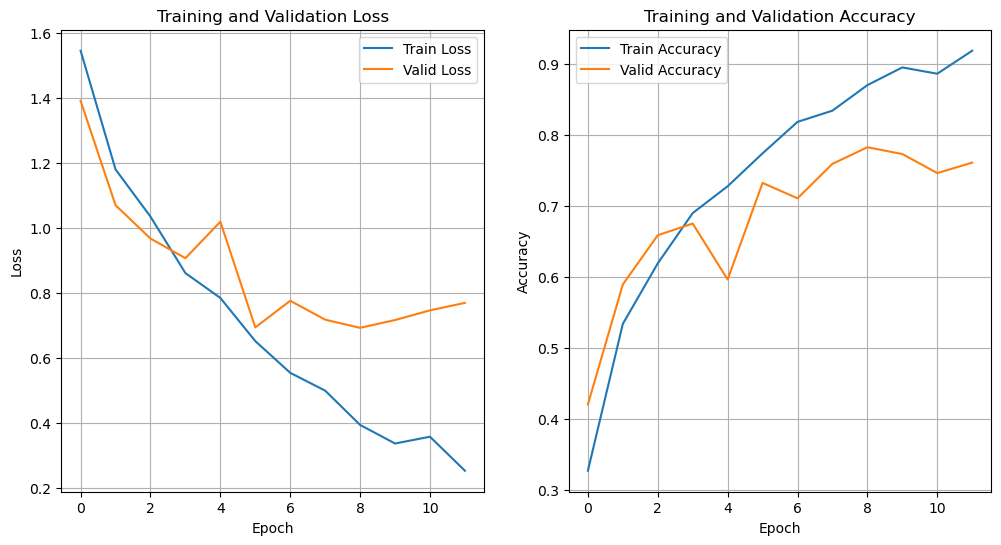


Loading best baseline model for final evaluation (Q2e)...
Baseline Test Loss: 0.457 | Baseline Test Acc: 85.74%

--- Topic-wise Classification Report (Q2e) ---
              precision    recall  f1-score   support

        ENTY     0.8429    0.6277    0.7195        94
         HUM     0.8806    0.9077    0.8939        65
        DESC     0.8506    0.9493    0.8973       138
         NUM     0.8833    0.9381    0.9099       113
         LOC     0.8333    0.8642    0.8485        81
        ABBR     1.0000    0.5556    0.7143         9

    accuracy                         0.8600       500
   macro avg     0.8818    0.8071    0.8306       500
weighted avg     0.8603    0.8600    0.8551       500



In [4]:
# === Section 4: Baseline Model Training (Q2a, c, e) ===

# 1. Set Hyperparameters (This is your answer to Q2a)
HIDDEN_DIM = 256
N_LAYERS = 1
BIDIRECTIONAL = False # Simple RNN
DROPOUT = 0.5
N_EPOCHS = 20         # We can set this higher, early stopping will handle it
LEARNING_RATE = 1e-3
BATCH_SIZE = 64       # From data_pipeline
OPTIMIZER = 'Adam'
PATIENCE = 3          # For EarlyStopping: "a few epochs"

# 2. Instantiate Baseline Model (Final Hidden State)
model_baseline = RNN_Hidden(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
                           BIDIRECTIONAL, DROPOUT, PAD_IDX)

# 3. Define Optimizer and Loss
optimizer = optim.Adam(model_baseline.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
model_baseline = model_baseline.to(device)
criterion = criterion.to(device)

# 4. Training Loop
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

# --- MODIFIED: Use EarlyStopping ---
model_save_path = 'rnn-model-baseline.pth'
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=model_save_path)
# --- END MODIFICATION ---

print("Starting Baseline RNN model training...")

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_baseline, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate_epoch(model_baseline, valid_iterator, criterion)
    
    end_time = time.time()
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    # --- MODIFIED: EarlyStopping Check ---
    early_stopping(valid_loss, model_baseline)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
    # --- END MODIFICATION ---

print("\nBaseline Training complete.")

# 5. Plotting (Answer for Q2c)
print("Plotting training curves for Q2c...")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('rnn_baseline_training_curves.png')
plt.show()

# 6. Final Evaluation on Test Set (Answer for Q2e)
print("\nLoading best baseline model for final evaluation (Q2e)...")

model_baseline.load_state_dict(torch.load(model_save_path)) # Load the best model
test_loss, test_acc = evaluate_epoch(model_baseline, test_iterator, criterion)
print(f'Baseline Test Loss: {test_loss:.3f} | Baseline Test Acc: {test_acc*100:.2f}%')

model_baseline.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_iterator:
        predictions = model_baseline(batch.text)
        preds = predictions.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch.label.cpu().numpy())

print("\n--- Topic-wise Classification Report (Q2e) ---")
target_names = LABEL.vocab.itos
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# Save this for Q2d
baseline_test_acc = test_acc

In [5]:
# === Section 5: Experiment 1 - Regularization (Q2b) ===

# --- Hyperparameters for the experiment ---
HIDDEN_DIM = 256
N_LAYERS = 1
BIDIRECTIONAL = False
N_EPOCHS = 20 # Max epochs
LEARNING_RATE = 1e-3
PATIENCE = 3

# --- Regularization strategies to test ---
reg_strategies = {
    "Baseline (No Reg)": {'dropout': 0.0, 'weight_decay': 0.0},
    "Dropout (0.5)":     {'dropout': 0.5, 'weight_decay': 0.0},
    "L2 (Weight Decay)": {'dropout': 0.0, 'weight_decay': 1e-4},
    "Dropout + L2":      {'dropout': 0.5, 'weight_decay': 1e-4}
}

reg_results = {}

print("Starting Regularization Experiment (Q2b)...")

for name, config in reg_strategies.items():
    
    print(f"\n--- Testing Strategy: {name} ---")
    
    model = RNN_Hidden(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
                       BIDIRECTIONAL, config['dropout'], PAD_IDX)
    
    optimizer = optim.Adam(model.parameters(), 
                           lr=LEARNING_RATE, 
                           weight_decay=config['weight_decay'])
    
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    criterion = criterion.to(device)
    
    model_save_path = f'rnn-model-{name}.pth'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=model_save_path)
    
    # 4. Train the model
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate_epoch(model, valid_iterator, criterion)
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # 5. Evaluate on test set
    model.load_state_dict(torch.load(model_save_path))
    test_loss, test_acc = evaluate_epoch(model, test_iterator, criterion)
    print(f'--- Test Result for {name}: Test Acc: {test_acc*100:.2f}% ---')
    reg_results[name] = test_acc

print("\n--- Regularization Experiment Complete (Q2b) ---")
print("Final Test Accuracies:")
for name, acc in reg_results.items():
    print(f"  {name}: {acc*100:.2f}%")

Starting Regularization Experiment (Q2b)...

--- Testing Strategy: Baseline (No Reg) ---
Early stopping at epoch 7
--- Test Result for Baseline (No Reg): Test Acc: 86.51% ---

--- Testing Strategy: Dropout (0.5) ---
Early stopping at epoch 9
--- Test Result for Dropout (0.5): Test Acc: 80.96% ---

--- Testing Strategy: L2 (Weight Decay) ---
Early stopping at epoch 8
--- Test Result for L2 (Weight Decay): Test Acc: 84.48% ---

--- Testing Strategy: Dropout + L2 ---
Early stopping at epoch 8
--- Test Result for Dropout + L2: Test Acc: 78.61% ---

--- Regularization Experiment Complete (Q2b) ---
Final Test Accuracies:
  Baseline (No Reg): 86.51%
  Dropout (0.5): 80.96%
  L2 (Weight Decay): 84.48%
  Dropout + L2: 78.61%


In [6]:
# === Section 6: Experiment 2 - Aggregation (Q2d) ===

# We'll use the best regularization setting from Q2b (assume Dropout=0.5)
BEST_DROPOUT = 0.5 
HIDDEN_DIM = 256
N_LAYERS = 1
BIDIRECTIONAL = False
N_EPOCHS = 20 # Max epochs
LEARNING_RATE = 1e-3
PATIENCE = 3

# --- Aggregation strategies to test ---
aggregation_strategies = [
    (RNN_Hidden, "Final Hidden State"),
    (RNN_AvgPool, "Average Pooling"),
    (RNN_MaxPool, "Max Pooling")
]

agg_results = {}

print("\n\nStarting Aggregation Experiment (Q2d)...")

for model_class, name in aggregation_strategies:
    
    print(f"\n--- Testing Strategy: {name} ---")
    
    model = model_class(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
                        BIDIRECTIONAL, BEST_DROPOUT, PAD_IDX)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    criterion = criterion.to(device)
    
    model_save_path = f'rnn-model-{name}.pth'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=model_save_path)
    
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate_epoch(model, valid_iterator, criterion)
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch+1}')
            break

    model.load_state_dict(torch.load(model_save_path))
    test_loss, test_acc = evaluate_epoch(model, test_iterator, criterion)
    print(f'--- Test Result for {name}: Test Acc: {test_acc*100:.2f}% ---')
    agg_results[name] = test_acc

print("\n--- Aggregation Experiment Complete (Q2d) ---")
print("Final Test Accuracies:")
for name, acc in agg_results.items():
    print(f"  {name}: {acc*100:.2f}%")



Starting Aggregation Experiment (Q2d)...

--- Testing Strategy: Final Hidden State ---
Early stopping at epoch 11
--- Test Result for Final Hidden State: Test Acc: 77.96% ---

--- Testing Strategy: Average Pooling ---
Early stopping at epoch 9
--- Test Result for Average Pooling: Test Acc: 84.57% ---

--- Testing Strategy: Max Pooling ---
Early stopping at epoch 12
--- Test Result for Max Pooling: Test Acc: 88.01% ---

--- Aggregation Experiment Complete (Q2d) ---
Final Test Accuracies:
  Final Hidden State: 77.96%
  Average Pooling: 84.57%
  Max Pooling: 88.01%
